In [6]:
from google.colab import drive
drive.mount('/content/drive')
! cp -r /content/drive/MyDrive/Study/MIPT_magistery/qualification_work/data .

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data_norm = pd.DataFrame(data=np.random.normal(
                        loc=0, scale=1, size=(1000, 2)), 
                       columns=['x', 'y'])
data_noise = pd.DataFrame(data=np.random.uniform(
                        low=-6, high=6, size=(int(data_norm.shape[0]*.05), data_norm.shape[1])), 
                        columns=['x', 'y'])
filter = (
    (data_noise['x'] < data_norm['x'].min())
    | (data_noise['x'] > data_norm['x'].max())
    | (data_noise['y'] < data_norm['y'].min())
    | (data_noise['y'] > data_norm['y'].max())
    )
data_noise = data_noise[filter]
data_norm['anomaly'] = 0
data_noise['anomaly'] = 1

In [ ]:
df_norm = pd.concat((data_norm, data_noise))

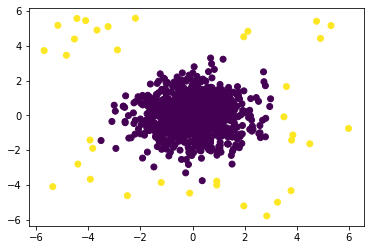

In [ ]:
plt.scatter(df_norm['x'], df_norm['y'], c=df_norm['anomaly'])
plt.show()

In [ ]:
from scipy.stats import kstest

def check_shapiro(df, alpha=0.05):
    columns = list(df.columns)
    cols_with_pos_res = []
    if 'norm' in columns:
        columns.remove('norm')
    for col in columns:
        if kstest(df[col], 'norm').pvalue > alpha:
            cols_with_pos_res.append(col)
    return cols_with_pos_res

def outliers_z_score(data, feature):
    x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
    return outliers

norm_cols = check_shapiro(df_norm)
if norm_cols:
    outliers = pd.DataFrame()
    for col in norm_cols:
        outliers = pd.concat((outliers, outliers_z_score(df_norm, col)))
    outliers = outliers.drop_duplicates()
outliers['anomaly'].value_counts()

Число выбросов по методу z-отклонения: 19
Число выбросов по методу z-отклонения: 24


1    33
0     1
Name: anomaly, dtype: int64

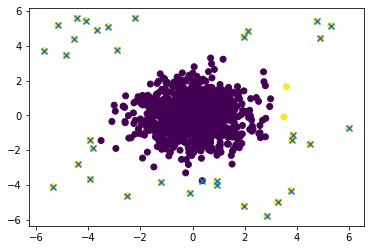

In [ ]:
plt.scatter(df_norm['x'], df_norm['y'], c=df_norm['anomaly'])
plt.scatter(outliers['x'], outliers['y'], marker='x')
plt.show()

# Работа с данными SKAB

In [10]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [13]:
all_files=[]
import os
for root, dirs, files in os.walk("data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [14]:
dfs=[]
for path in all_files:
    df = pd.read_csv(path,index_col='datetime',sep=';',parse_dates=True)
    print(path, df.shape)
    dfs.append(df)
print('Features:')
for col in dfs[2].columns:
    print('\t',col)

data/other/11.csv (1190, 10)
data/other/8.csv (1147, 10)
data/other/13.csv (923, 10)
data/other/3.csv (1137, 10)
data/other/7.csv (1090, 10)
data/other/12.csv (1048, 10)
data/other/1.csv (745, 10)
data/other/14.csv (905, 10)
data/other/10.csv (1327, 10)
data/other/5.csv (1155, 10)
data/other/9.csv (1144, 10)
data/other/4.csv (1191, 10)
data/other/6.csv (1147, 10)
data/other/2.csv (780, 10)
data/anomaly-free/anomaly-free.csv (9405, 8)
data/valve2/3.csv (995, 10)
data/valve2/1.csv (1063, 10)
data/valve2/0.csv (1125, 10)
data/valve2/2.csv (1129, 10)
data/valve1/11.csv (1141, 10)
data/valve1/8.csv (1144, 10)
data/valve1/13.csv (1140, 10)
data/valve1/3.csv (1148, 10)
data/valve1/7.csv (1094, 10)
data/valve1/12.csv (1140, 10)
data/valve1/1.csv (1145, 10)
data/valve1/15.csv (1150, 10)
data/valve1/14.csv (1139, 10)
data/valve1/0.csv (1147, 10)
data/valve1/10.csv (1146, 10)
data/valve1/5.csv (1154, 10)
data/valve1/9.csv (1148, 10)
data/valve1/4.csv (1095, 10)
data/valve1/6.csv (1154, 10)
data/v

In [15]:
dfs = [df for df in dfs if df.shape[1] == 10]

In [16]:
df = pd.concat(dfs)
df = df.drop_duplicates()
df

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-02-08 18:10:42,0.240983,0.287449,2.879000,0.054711,85.6509,31.3986,239.224,128.0000,0.0,0.0
2020-02-08 18:10:43,0.241153,0.285669,2.696420,0.054711,85.6603,31.4021,219.711,128.6890,0.0,0.0
2020-02-08 18:10:44,0.246551,0.287455,2.582570,0.382638,85.7871,31.4064,227.685,128.3130,0.0,0.0
2020-02-08 18:10:45,0.238680,0.282037,2.207200,0.382638,85.7108,31.4064,231.119,129.3790,0.0,0.0
2020-02-08 18:10:46,0.238926,0.285487,0.936421,0.382638,85.9412,31.4226,216.516,128.6280,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-03-09 11:14:29,0.027259,0.039960,0.976074,0.054711,71.9306,25.5352,216.136,32.0000,0.0,0.0
2020-03-09 11:14:30,0.026799,0.039247,1.231140,-0.601143,71.9669,25.5273,238.335,32.0000,0.0,0.0
2020-03-09 11:14:31,0.026937,0.038426,1.475480,0.054711,71.8970,25.5313,246.615,31.9966,0.0,0.0


(<AxesSubplot:>, 0.0    0.646073
 1.0    0.353927
 Name: anomaly, dtype: float64)

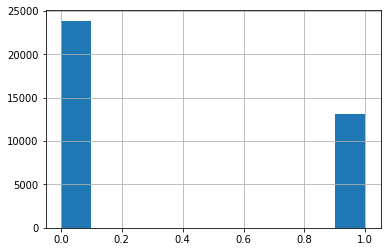

In [17]:
df['anomaly'].hist(), df['anomaly'].value_counts(normalize=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36920 entries, 2020-02-08 18:10:42 to 2020-03-09 11:14:33
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Accelerometer1RMS    36920 non-null  float64
 1   Accelerometer2RMS    36920 non-null  float64
 2   Current              36920 non-null  float64
 3   Pressure             36920 non-null  float64
 4   Temperature          36920 non-null  float64
 5   Thermocouple         36920 non-null  float64
 6   Voltage              36920 non-null  float64
 7   Volume Flow RateRMS  36920 non-null  float64
 8   anomaly              36920 non-null  float64
 9   changepoint          36920 non-null  float64
dtypes: float64(10)
memory usage: 3.1 MB


In [19]:
df = df.drop('changepoint', axis=1)

In [20]:
X = df.copy()
y = X.pop('anomaly')
X.shape, y.shape

((36920, 8), (36920,))

In [21]:
from sklearn.preprocessing import StandardScaler
columns = list(X.columns)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(data=X, columns=columns)

In [22]:
from scipy.stats import kstest

def check_shapiro(df):
    columns = list(df.columns)
    for col in columns:
        print(col, kstest(df[col], 'norm'), kstest(df[col], 'norm').pvalue > 0.05)

check_shapiro(X)

Accelerometer1RMS KstestResult(statistic=0.3302693297383307, pvalue=0.0) False
Accelerometer2RMS KstestResult(statistic=0.3317661251502749, pvalue=0.0) False
Current KstestResult(statistic=0.16592688950810242, pvalue=0.0) False
Pressure KstestResult(statistic=0.27619994117967284, pvalue=0.0) False
Temperature KstestResult(statistic=0.24686462003458043, pvalue=0.0) False
Thermocouple KstestResult(statistic=0.21040552606575086, pvalue=0.0) False
Voltage KstestResult(statistic=0.048608730802270295, pvalue=2.99431664999395e-76) False
Volume Flow RateRMS KstestResult(statistic=0.37233790436877795, pvalue=0.0) False


In [23]:
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest

iForest = IsolationForest(n_estimators=50, verbose=1)
iForest.fit(X)
pred = iForest.predict(X)
pred[pred == 1] = 0
pred[pred == -1] = 1
f1_score(y, pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


0.384993384993385

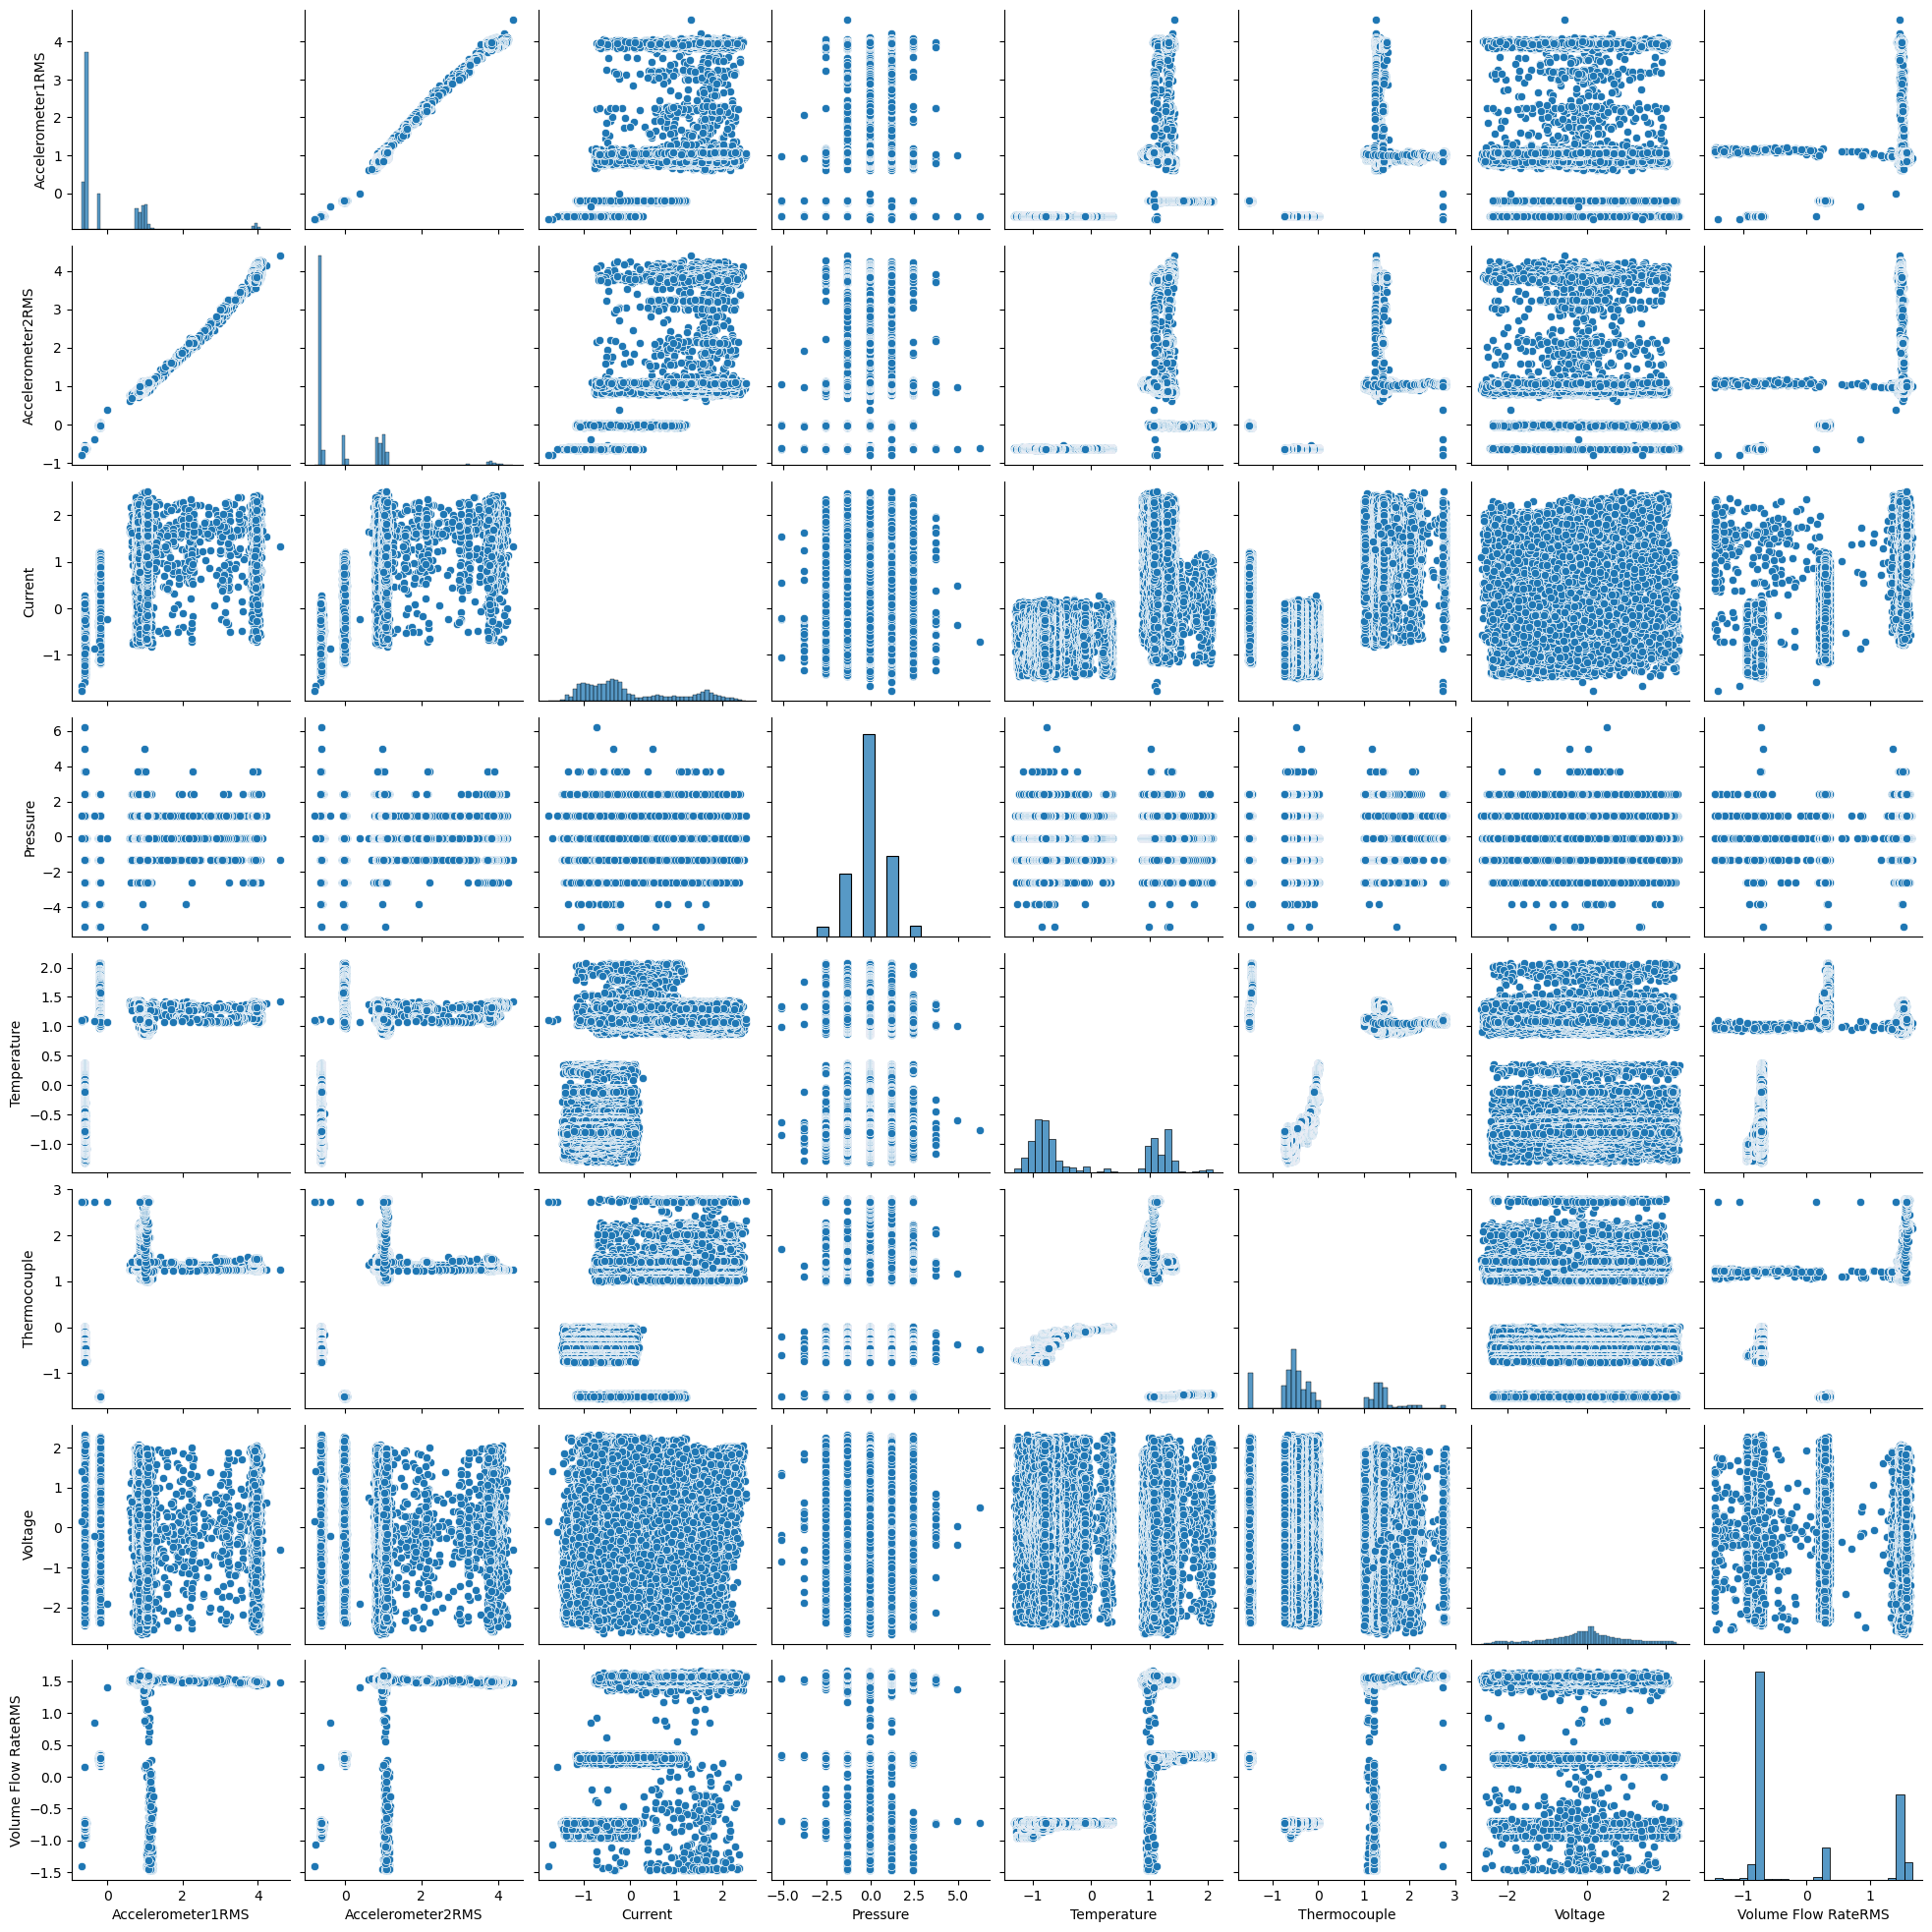

In [ ]:
import seaborn as sns

sns.pairplot(X)